In [1]:
%pylab inline
from IPython.display import display, Math, Latex
maths = lambda s: display(Math(s))
latex = lambda s: display(Latex(s))

Populating the interactive namespace from numpy and matplotlib


A binary variable is good for representing something like a coin toss, but normally we want to have more states, such as the number rolled on a die. One way of representing such a variable is 1-of-K  representation, where we have a vector $\mathbf{x}$ of size $K$ where state $k$ is represented by the $k^{th}$ element being 1 and all other elements being 0.

In [2]:
def one_of(K, k):
    # If k is an array, have each output row
    # represent an element of k
    k = array(k).flatten()
    x = zeros((k.shape[0],K))
    x[range(len(k)),k] = 1
    return x

In [3]:
# For example
one_of(10,5)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

For example we can create a die

In [4]:
class Die(object):
    def __init__(self, mu=None, sides=6):
        if mu is None:
            mu = [1] * sides
        # Normalise to be prob. dist.
        self.mu = array(mu, float)/sum(mu)
        self.sides = sides
        
    def roll(self, n):
        # sample using uniform rand num to index y axis of cdf
        rolls = argmax(cumsum(self.mu)[:,newaxis] > random.random(n),0)
        return one_of(self.sides, rolls)

And roll some numbers on a fair die

In [5]:
fairdie = Die()
fairrolls = fairdie.roll(5)

print(fairrolls)
print("As (0-based) numbers:", argmax(fairrolls, axis=1))

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
As (0-based) numbers: [1 2 5 3 3]


If we have a loaded die, we can define a vector $\boldsymbol{\mu}$ of the probability for rolling each number

In [6]:
# Say rolling a 1 is twice as likely as the other numbers
nums = [2, 1, 1, 1, 1, 1]
# normalise
mu = array(nums, float)/sum(nums)
print(mu)
latex(r"Probabilities, so normalised s.t. $\sum_{k=1}^{K} \mu_k = %s$" % round(sum(mu)))

[0.28571429 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]


<IPython.core.display.Latex object>

(array([302., 150., 143., 127., 143., 135.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

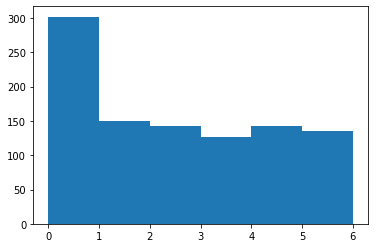

In [7]:
# roll some numbers on our loaded die
loadeddie = Die(mu)
loadedrolls = loadeddie.roll(1000)

hist(argmax(loadedrolls,1), bins=range(loadeddie.sides+1))

Our probability distribution is just given by $\mu_k$ for each $k$, i.e. $p(k|\boldsymbol{\mu}) = \mu_k$ (a generalisation of the Bernoulli distribution, called the Categorical distribution)

But we want to use one-of-K to represent $k$ by vector $\mathbf{x}$, so we can write it as

$p(\mathbf{x}|\boldsymbol{\mu}) = \prod_{k=1}^K \mu_k^{x_k}$ 

This works because $\mu_k^{x_k}$ will be 1 for every element except that where $x_n$ = 1, so the product will give the $\mu_k$ for the state represented by $\mathbf{x}$. It is just a clever way of "picking out" the correct $\mu_k$.

In [8]:
print(mu**[0,1,0,0,0,0])

# only kth element is non-1

[1.         0.14285714 1.         1.         1.         1.        ]


In [9]:
# Define our probability mass function
Die.pmf = lambda self, x: prod(self.mu**x, axis=-1)

Some examples with our weighted die

In [10]:
x1 = [1,0,0,0,0,0] # "roll a one"
x2 = [0,1,0,0,0,0] # "roll a two"

p1 = loadeddie.pmf(x1)
p2 = loadeddie.pmf(x2)

maths(r"p(\mathbf{x}=%s|\boldsymbol{\mu}) = %s" % (x1,p1))
maths(r"p(\mathbf{x}=%s|\boldsymbol{\mu}) = %s" % (x2,p2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now consider the likelihood over N observations -- we simply need to multiply the previous result over all the samples

$p(D|\mu) = \prod_{n=1}^{N}p(\boldsymbol{x}_n|\boldsymbol{\mu})=$

$= \prod_{n=1}^{N}\prod_{k=1}^K \mu_k^{x_k}$ 

In [11]:
Die.likelihood = lambda self, data: product(self.pmf(data))
Die.loglikelihood = lambda self, data: sum(log(self.pmf(data)))

Now given some observed dice rolls, we can plot how likely it is that the number one is weighted a certain way

Text(0.5, 0, '$\\mu_1$')

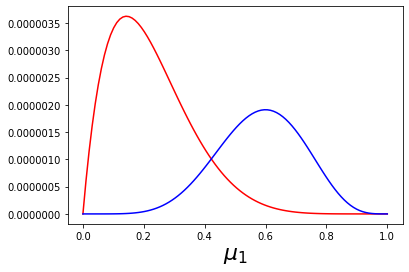

In [12]:
def plot_likelihood_1(r, *a, **kw):
    prob_roll_1 = linspace(0,1,100)
    ps = []

    for p1 in prob_roll_1:
        # Vary the probability of rolling a 1, and 
        # divide the remaining probability equally
        # among the other 5 numbers
        mus = (ones(6) * (1-p1))/5.
        mus[0] = p1
        ps.append(Die(mus).likelihood(r))
    
    plot(prob_roll_1, ps, *a, **kw)

# Plot some arbitrary data (where "0" means rolling a one)
plot_likelihood_1(one_of(6,[0,2,1,5,3,1,1]), 'red')
plot_likelihood_1(one_of(6,[1,0,1,2,0,1,0,0,0,0]), 'blue')
    
xlabel(r"$\mu_1$", size=22)

Text(0, 0.5, 'Likelihood')

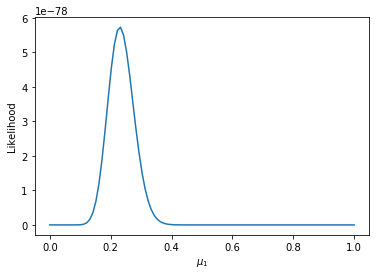

In [13]:
# Using some samples from our loaded die
plot_likelihood_1(loadeddie.roll(100))
xlabel(r"$\mu_1$")
ylabel('Likelihood')

We can also write the likelihood as

$p(D|\boldsymbol{\mu}) = \prod_{k=1}^K \mu_k^{m_k}$

Where $m_k$ is the number of data points where $x_k = 1$

Now to find the maximum likelihood solution for $\boldsymbol{\mu}$, we maximise $\log p(D|\boldsymbol{\mu})$ with the constraint that $\sum_{k=1}^{K}\mu_k = 1$, which we can enforce using a Lagrange multiplier $\lambda$.

$\frac{\partial}{\partial \mu_k}[\sum_{j=1}^{K}m_j \log \mu_j + \lambda(\sum_{j=1}^{K}\mu_j - 1)] = 0$

$\frac{m_k}{\mu_k} + \lambda(1 - 1) = 0$ (The partial derivative of terms in the summations where $j \neq k$ vanish)

$\mu_k = -\frac{m_k}{\lambda}$

Sub into $\sum_{k=1}^{K}\mu_k = 1$

$-\sum_{k=1}^{K} m_k = \lambda$

so $\lambda = -N$ (because the summation over the number of data points in each state gives the total number of data points)

And $\mu_k^{ML} = \frac{m_k}{N}$ (which is just the fraction of the data points where $x_k=1$)

Now consider the distribution over the $m_k$s, which would give the number of ones, twos, threes etc. rolled, the same way the Binomial gave us the number of heads. It is called the Multinomial:

$\operatorname{Mult}(m_1,m_2,...,m_K|\boldsymbol{\mu},N) = \binom{N}{m_1 m_2 ... m_K} \prod_{k=1}^K \mu_k^{m_k}$    

In [14]:
from scipy.special import factorial

def multinomialpmf(ms, mu):
    # ms: the number of observations of each state
    ms = array(ms, float)
    # We normalise our weights mu, so the input can be unnormalised
    mu = array(mu, float)/sum(mu)
    # The number of observations can be inferred from ms
    N = sum(ms)
    norm = factorial(N)/prod(factorial(ms))
    return norm * prod(mu**ms)

We cannot really plot the multinomial directly, because of the many dimensions of $\boldsymbol{m}$.

But we can show the distribution of the number of ones rolled (constraining the other numbers), and with various weighted dice.

Text(0.5, 1.0, 'Probability of rolling $m_1$ ones')

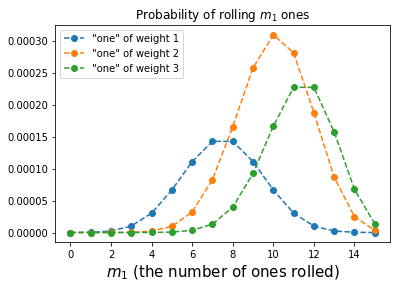

In [15]:
n = 15 # max number of ones
m1s = arange(n+1)
N = 35

for w1 in [1,2,3]:
    probs = []
    for m1 in m1s:
        # constrain so always sums to N
        ms = [m1,5,5,5,5,n-m1]
        assert sum(ms) == N
        probs.append(multinomialpmf(ms,[w1,1,1,1,1,1]))
    plot(m1s, probs, 'o--', label='"one" of weight %s' % w1)
    
xlabel("$m_1$ (the number of ones rolled)", size=15)
legend(loc='upper left')
title("Probability of rolling $m_1$ ones")

And we can plot the distribution over a magical 3-sided die in 2D with a colourmap (only showing two variables on the axes, since the third can be inferred as they sum to N)

Text(0.5, 1.0, 'pmf of "three sided" die with weights [2,1,1]')

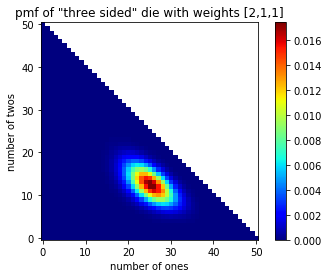

In [16]:
N = 50
ms = arange(N+1)

# default to NaN (so white background for region where sum>N)
o = ones((N+1,N+1)) * NaN

for m1 in ms:
    for m2 in arange((N-m1)+1):
        m3 = N - m1 - m2
        assert (m1 + m2 + m3) == N
        assert (m3 >= 0)
        o[m2,m1] = multinomialpmf([m1,m2,m3],[2,1,1])
                
jet()
imshow(o, origin='lower')
xlabel("number of ones")
ylabel("number of twos")
colorbar()
title('pmf of "three sided" die with weights [2,1,1]')